In [2]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [3]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

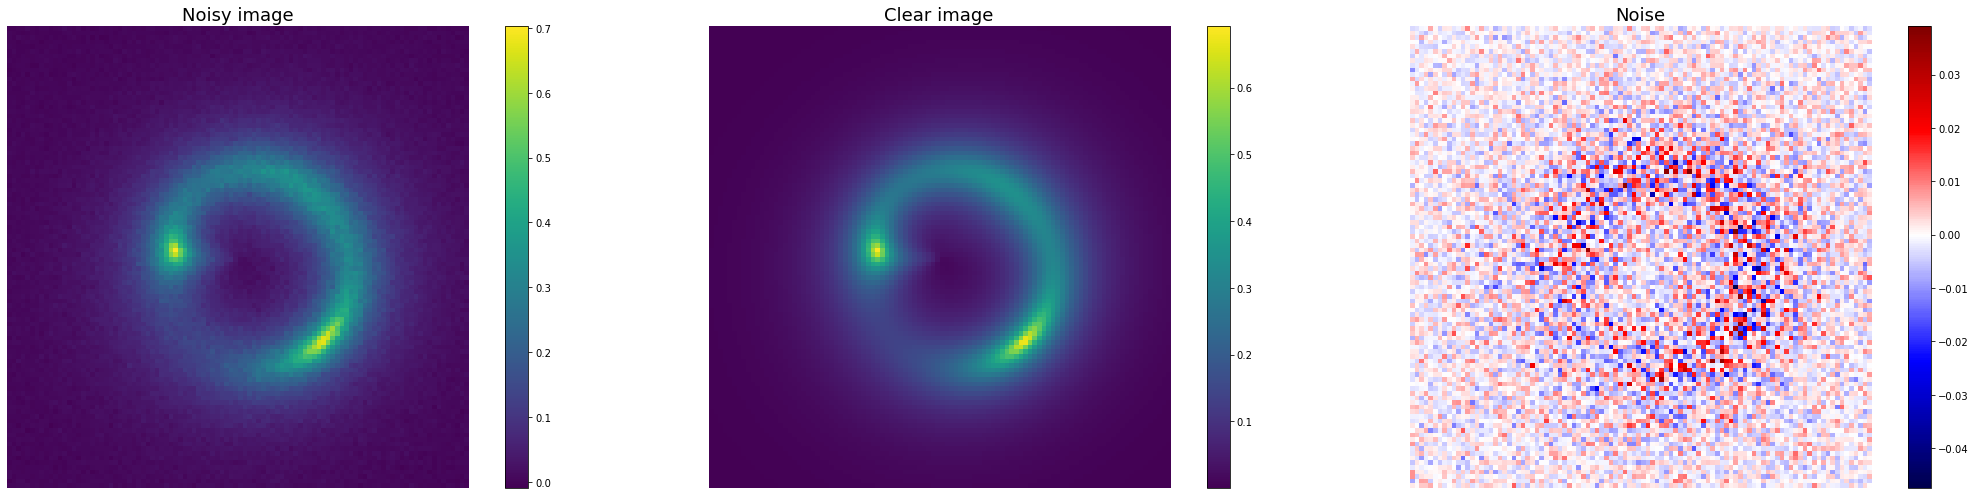

In [4]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# Likelihood images

In [5]:
logA_center_array=np.linspace(-9,-6.75,96)
Beta_center_array=np.linspace(1,5,96)

logA_step=logA_center_array[1]-logA_center_array[0]
Beta_step=Beta_center_array[1]-Beta_center_array[0]

Beta_min=1-math.floor(1/Beta_step)*Beta_step

Beta_long_array=np.arange(Beta_min,9,step=Beta_step)
Beta_left_array=np.arange(Beta_min,1,step=Beta_step)
Beta_right_array=np.arange(5+Beta_step,9,step=Beta_step)

logA_up_array=np.arange(-6.75+logA_step,-6.75+logA_step*33,step=logA_step)
logA_down_array=np.arange(-9-logA_step*32,-9,step=logA_step)

logA_full_array=np.append(logA_down_array,logA_center_array)
logA_full_array=np.append(logA_full_array,logA_up_array)

Beta_full_array=np.append(Beta_left_array,Beta_center_array)
Beta_full_array=np.append(Beta_full_array,Beta_right_array)

del logA_center_array; del logA_down_array; del logA_up_array; del logA_step
del Beta_center_array; del Beta_left_array; del Beta_long_array; del Beta_right_array; del Beta_min; del Beta_step

In [6]:
logA_array=deepcopy(logA_full_array)
Beta_array=deepcopy(Beta_full_array)

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

Coarse_logA_array=logA_array[::11]
Coarse_Beta_array=Beta_array[::11]

Loss_tensor=np.load('./data/Loss_tensor.npz')['arr_0']

-8.976315789473684 8.831578947368433


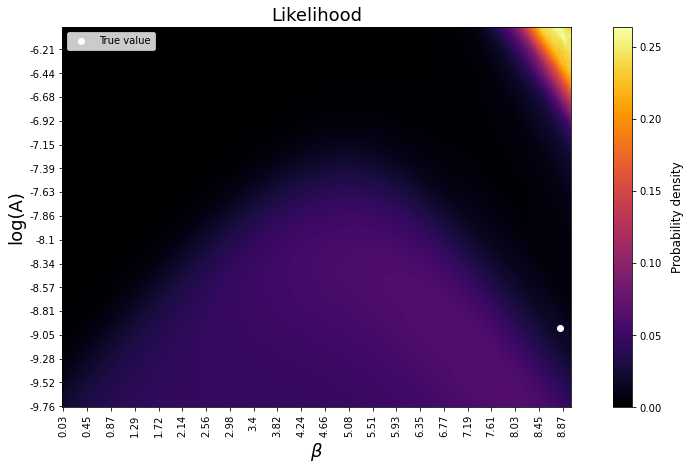

In [7]:
plt.figure(figsize=(15,7))

i=3
j=19
print(Coarse_logA_array[i],Coarse_Beta_array[j])

img=plt.imshow(np.exp(-Loss_tensor[i,j,0]/2),cmap='inferno')
plt.scatter(j*11,i*11,color='w',label='True value')
plt.legend(loc='upper left')


plt.gca().invert_yaxis()
plt.yticks(np.arange(0,len(y_labels),10),y_labels[::10])
plt.xticks(np.arange(0,len(x_labels),10),x_labels[::10],rotation=90)

plt.title('Likelihood',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Probability density',rotation=90,fontsize=12,labelpad=10)
plt.show()

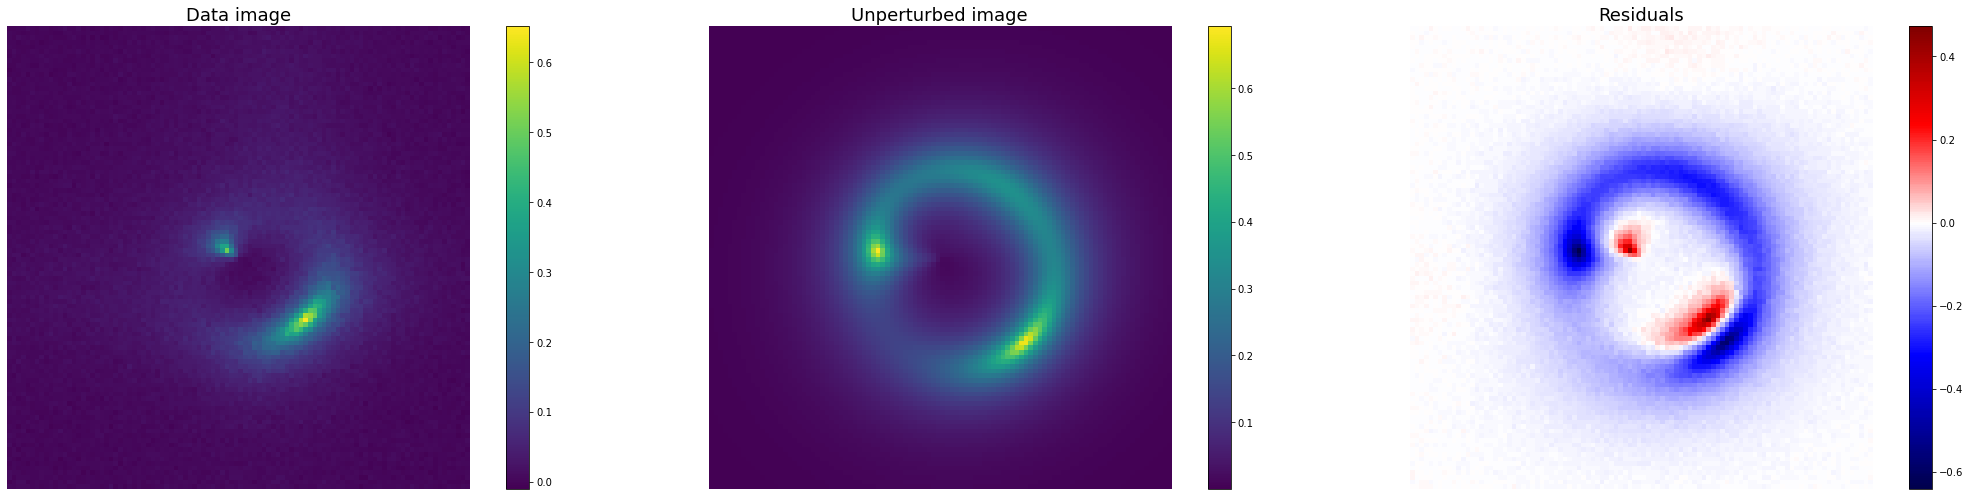

In [8]:
GRF_potential,data_image,fit_image,data_resid_spectrum=generate_data([Coarse_logA_array[i],Coarse_Beta_array[j]],1,Observation_conditions)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

-8.976315789473684 8.831578947368433


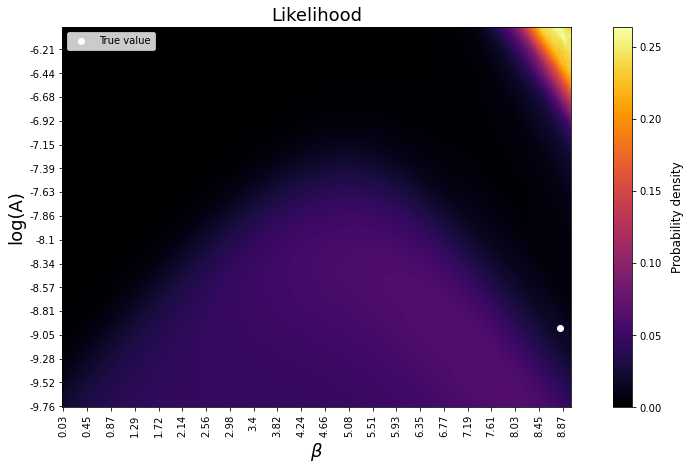

In [9]:
plt.figure(figsize=(15,7))

i=3
j=19
print(Coarse_logA_array[i],Coarse_Beta_array[j])

img=plt.imshow(np.exp(-Loss_tensor[i,j,0]/2),cmap='inferno')
plt.scatter(j*11,i*11,color='w',label='True value')
plt.legend(loc='upper left')


plt.gca().invert_yaxis()
plt.yticks(np.arange(0,len(y_labels),10),y_labels[::10])
plt.xticks(np.arange(0,len(x_labels),10),x_labels[::10],rotation=90)

plt.title('Likelihood',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Probability density',rotation=90,fontsize=12,labelpad=10)
plt.show()

# Perturbation limits

In [10]:
Physical_values_grid=np.load('data/Physical_values_grid/Physical_grid.npz')
GRF_potentials=Physical_values_grid['GRF_potentials']
GRF_deflections_x=Physical_values_grid['GRF_deflections_x']
GRF_deflections_y=Physical_values_grid['GRF_deflections_y']
GRF_convergence=Physical_values_grid['GRF_convergence']

In [11]:
logA_array_Physical=np.linspace(-8.5,-6.,32)
Beta_array_Physical=np.linspace(0,9,32)

In [12]:
std_potential=GRF_potentials.std(axis=(-2,-1)).mean(axis=-1)

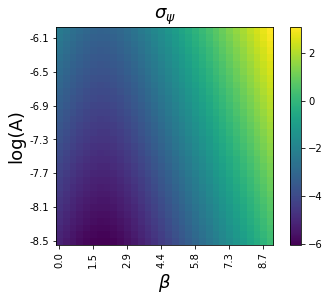

In [13]:
plt.imshow(np.log(std_potential))

plt.gca().invert_yaxis()
step=5
plt.yticks(np.arange(0,len(logA_array_Physical),step),logA_array_Physical[::step].round(1))
plt.xticks(np.arange(0,len(Beta_array_Physical),step),Beta_array_Physical[::step].round(1),rotation=90)

plt.title(r'$\sigma_{\psi}$',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.colorbar()

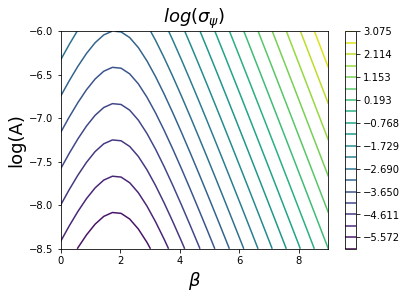

In [14]:
arr=np.log(std_potential)
plt.contour(Beta_array_Physical,logA_array_Physical,arr,np.linspace(arr.min(),arr.max(),20))

plt.title(r'$log(\sigma_{\psi})$',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)

plt.colorbar()

(-0.5, 99.5, 99.5, -0.5)

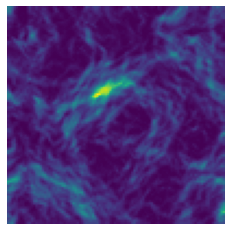

In [15]:
i=15
j=15
phi_index=0
plt.imshow(GRF_deflections_x[i,j,phi_index]**2+GRF_deflections_y[i,j,phi_index]**2)
plt.axis('off')

(array([ 713., 1836., 2599., 2360., 1501.,  688.,  208.,   54.,   23.,
          18.]),
 array([1.48888294e-04, 2.27578721e-02, 4.53668559e-02, 6.79758397e-02,
        9.05848234e-02, 1.13193807e-01, 1.35802791e-01, 1.58411775e-01,
        1.81020759e-01, 2.03629742e-01, 2.26238726e-01]),
 <BarContainer object of 10 artists>)

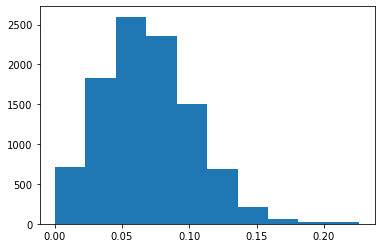

In [16]:
plt.hist(np.sqrt(GRF_deflections_x[i,j,phi_index]**2+GRF_deflections_y[i,j,phi_index]**2).flatten())

In [17]:
q=compute_radial_spectrum_pure(np.sqrt(GRF_deflections_x[i,j,phi_index]**2+GRF_deflections_y[i,j,phi_index]**2))

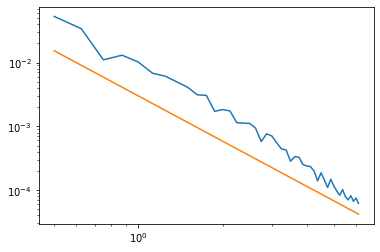

In [18]:
plt.loglog(Observation_conditions.frequencies,q)
plt.loglog(Observation_conditions.frequencies,(3e-3)*np.power(Observation_conditions.frequencies,-Beta_array_Physical[j]+2))

In [12]:
total_deflection=np.sqrt(GRF_deflections_x**2+GRF_deflections_y**2)

In [13]:
std_deflection=total_deflection.std(axis=(-2,-1)).mean(axis=-1)

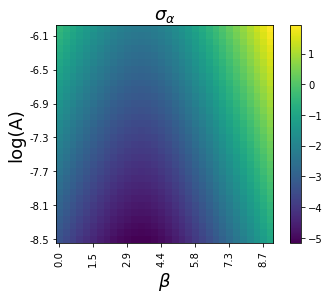

In [21]:
plt.imshow(np.log(std_deflection))

plt.gca().invert_yaxis()
step=5
plt.yticks(np.arange(0,len(logA_array_Physical),step),logA_array_Physical[::step].round(1))
plt.xticks(np.arange(0,len(Beta_array_Physical),step),Beta_array_Physical[::step].round(1),rotation=90)

plt.title(r'$\sigma_{\alpha}$',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.colorbar()

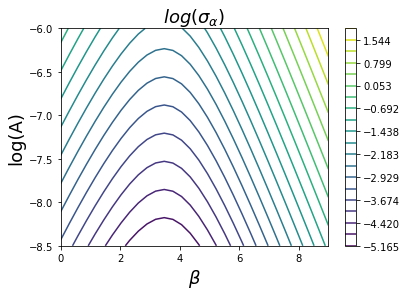

In [22]:
arr=np.log(std_deflection)
plt.contour(Beta_array_Physical,logA_array_Physical,arr,np.linspace(arr.min(),arr.max(),20))

plt.title(r'$log(\sigma_{\alpha})$',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)

plt.colorbar()

In [26]:
std_convergence=GRF_convergence.std(axis=(-2,-1)).mean(axis=-1)

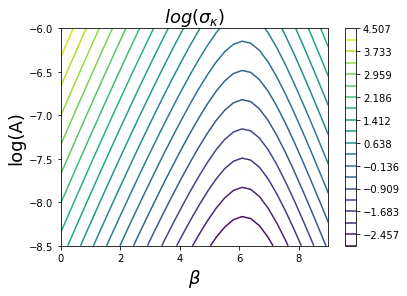

In [24]:
arr=np.log(std_convergence)
plt.contour(Beta_array_Physical,logA_array_Physical,arr,np.linspace(arr.min(),arr.max(),20))

plt.title(r'$log(\sigma_{\kappa}$)',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)

plt.colorbar()

# Figure out constraint

## Deflection based

In [210]:
from skimage import measure

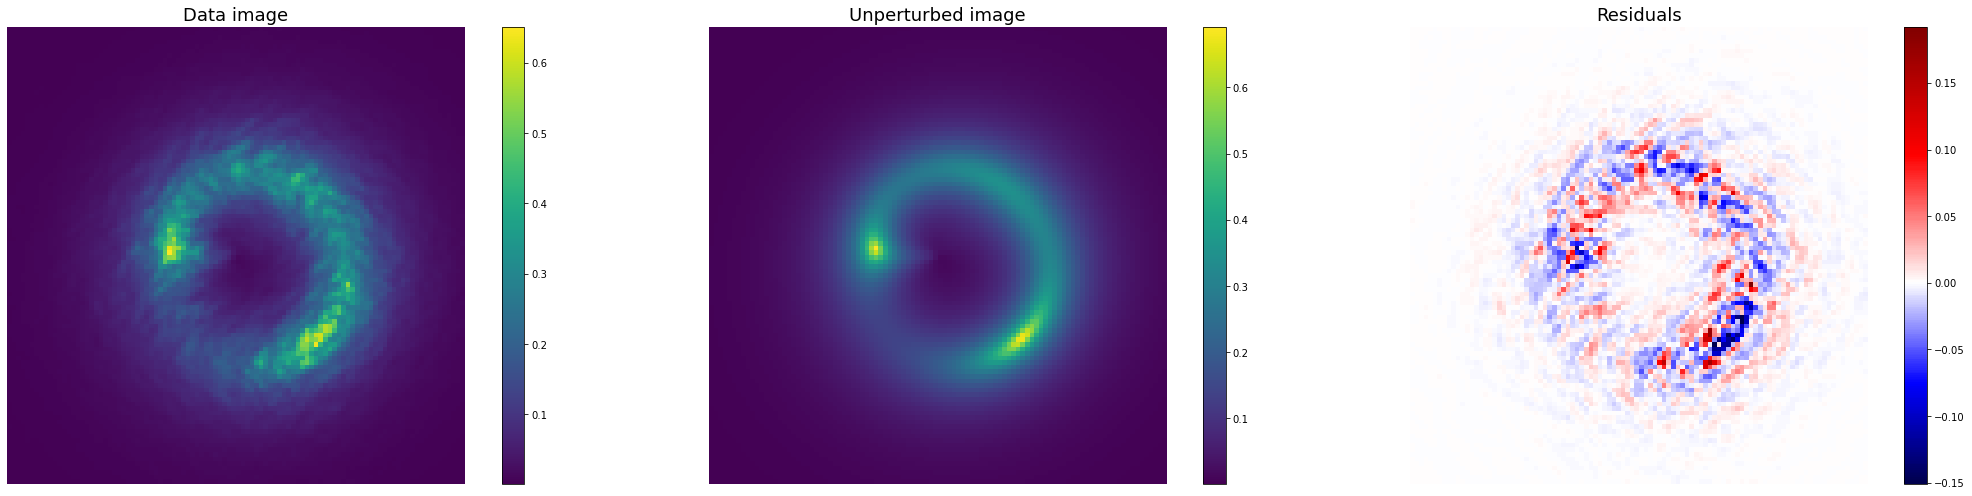

In [230]:
GRF_params=[-7.008,2.]
_,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [231]:
i=np.argmin(np.abs(logA_array_Physical-GRF_params[0]))
j=np.argmin(np.abs(Beta_array_Physical-GRF_params[1]))
thresh_def=np.log(std_deflection)[i,j]
print(np.log(std_deflection)[i,j])

-2.958390479117049


In [232]:
indices=measure.find_contours(np.log(std_deflection),np.log(std_deflection)[i,j])[0]

logA_values=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_values=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

step=len(indices)//5

crop_logA_arr=logA_values[::step]
crop_Beta_arr=Beta_values[::step]

In [233]:
data_images=np.zeros((len(crop_logA_arr),100,100))

for i in range(len(crop_logA_arr)):
    GRF_params=[crop_logA_arr[i],crop_Beta_arr[i]]
    _,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)
    data_images[i]=data_image

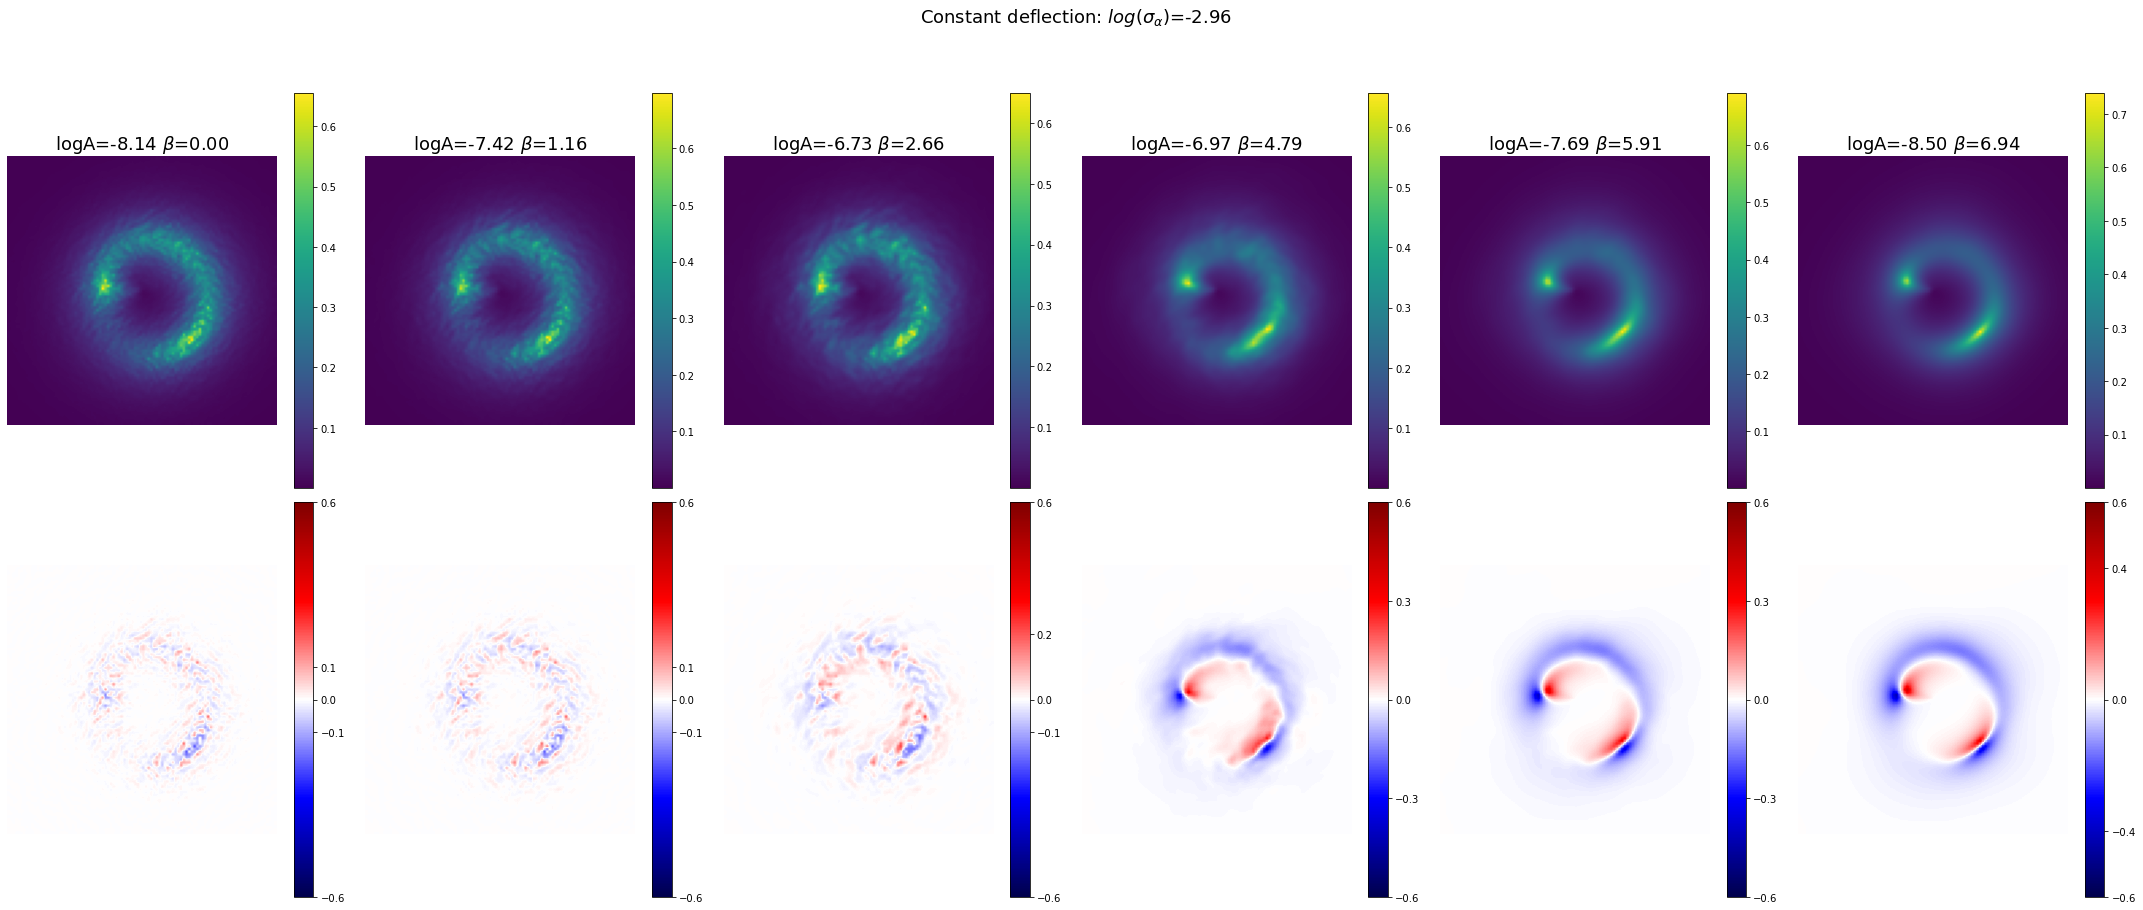

In [234]:
fig,ax=plt.subplots(2,len(crop_logA_arr),figsize=(30,12))

images=np.array([data_images,data_images-Image_unperturbed_noiseless])

#Normalized masked residuals
#images[1,:]/=np.sqrt(Observation_conditions.noise_var)
#images[1,:]*=Observation_conditions.annulus_mask


for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(len(crop_logA_arr)):
        axis=axis_row[j]
        image=images[i,j]
        
        if i==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
            axis.set_title('logA={:.2f} '.format(crop_logA_arr[j])+r'$\beta$'+'={:.2f}'.format(crop_Beta_arr[j]),fontsize=FS)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-0.6,0.6))
            #img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[-0.6,math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1,0.6]
    
            #cbar=fig.colorbar(img,ax=axis,fraction=0.045)
            #cbar=fig.colorbar(img,ax=axis,ticks=[-0.7,0,0.7],fraction=0.045)
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders)
            #cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
            #cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.axis('off')
        
plt.suptitle('Constant deflection: '+r'$log(\sigma_{\alpha})$'+'={:.2f}'.format(thresh_def),fontsize=FS,y=1.05)
plt.tight_layout()
plt.show()

# I would pick log(sigma(alpha))=-3 as a threshold of perturbations

In [20]:
from skimage import measure
indices=measure.find_contours(np.log(std_deflection),-3)[0]

logA_threshold=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_threshold=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

logA_threshold_indices=(logA_threshold-logA_array[0])/(logA_array[1]-logA_array[0])
Beta_threshold_indices=(Beta_threshold-Beta_array[0])/(Beta_array[1]-Beta_array[0])

In [33]:
indices=measure.find_contours(np.log(std_convergence),-2)[0]

logA_conv=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_conv=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

logA_conv_indices=(logA_conv-logA_array[0])/(logA_array[1]-logA_array[0])
Beta_conv_indices=(Beta_conv-Beta_array[0])/(Beta_array[1]-Beta_array[0])

-8.976315789473684 8.831578947368433


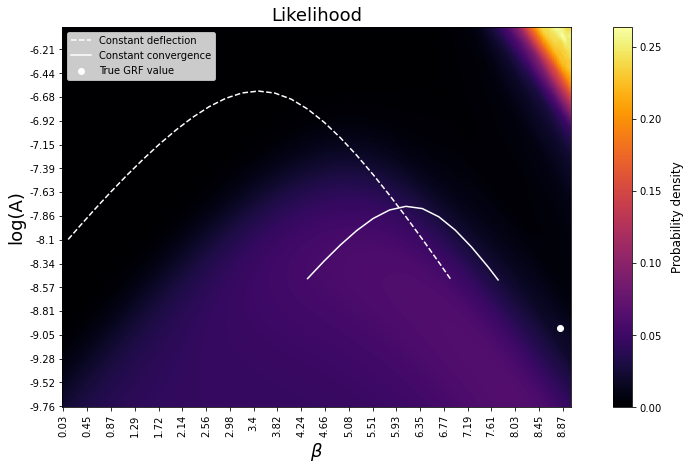

In [37]:
plt.figure(figsize=(15,7))

i=3
j=19
print(Coarse_logA_array[i],Coarse_Beta_array[j])


plt.plot(Beta_threshold_indices[1:],logA_threshold_indices[1:],color='white',label='Constant deflection',linestyle='--')
plt.plot(Beta_conv_indices[1:],logA_conv_indices[1:],color='white',label='Constant convergence')

img=plt.imshow(np.exp(-Loss_tensor[i,j,0]/2),cmap='inferno')
plt.scatter(j*11,i*11,color='w',label='True GRF value')
plt.legend(loc='upper left')


plt.gca().invert_yaxis()
plt.yticks(np.arange(0,len(y_labels),10),y_labels[::10])
plt.xticks(np.arange(0,len(x_labels),10),x_labels[::10],rotation=90)

plt.title('Likelihood',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Probability density',rotation=90,fontsize=12,labelpad=10)
plt.show()

## Potential based

In [217]:
from skimage import measure

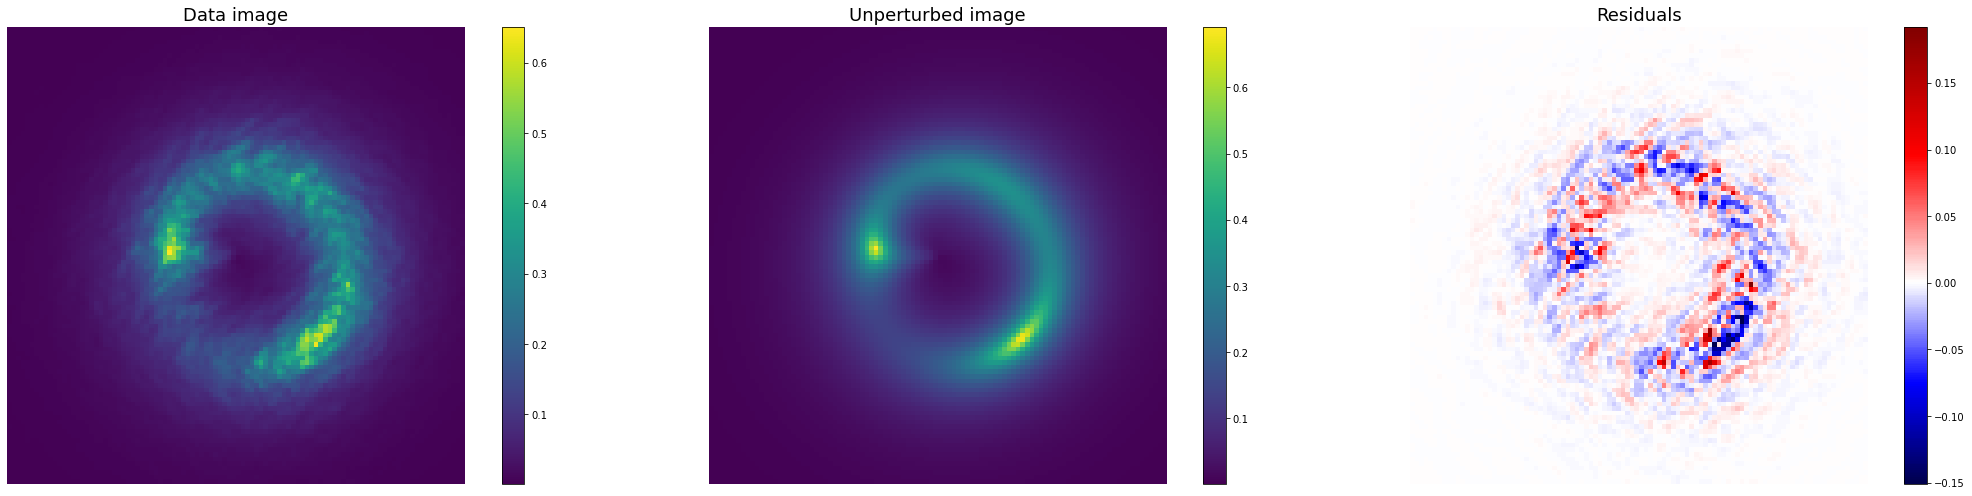

In [218]:
GRF_params=[-7.008,2.]
_,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [219]:
i=np.argmin(np.abs(logA_array_Physical-GRF_params[0]))
j=np.argmin(np.abs(Beta_array_Physical-GRF_params[1]))
thresh_pot=np.log(std_potential)[i,j]
print(thresh_pot)

-4.276926084097435


In [220]:
indices=measure.find_contours(np.log(std_potential),thresh_pot)[0]

logA_values=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_values=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

step=len(indices)//5

crop_logA_arr=logA_values[::step]
crop_Beta_arr=Beta_values[::step]

In [130]:
step=len(indices)//5

In [221]:
data_images=np.zeros((len(crop_logA_arr),100,100))

for i in range(len(crop_logA_arr)):
    GRF_params=[crop_logA_arr[i],crop_Beta_arr[i]]
    _,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)
    data_images[i]=data_image

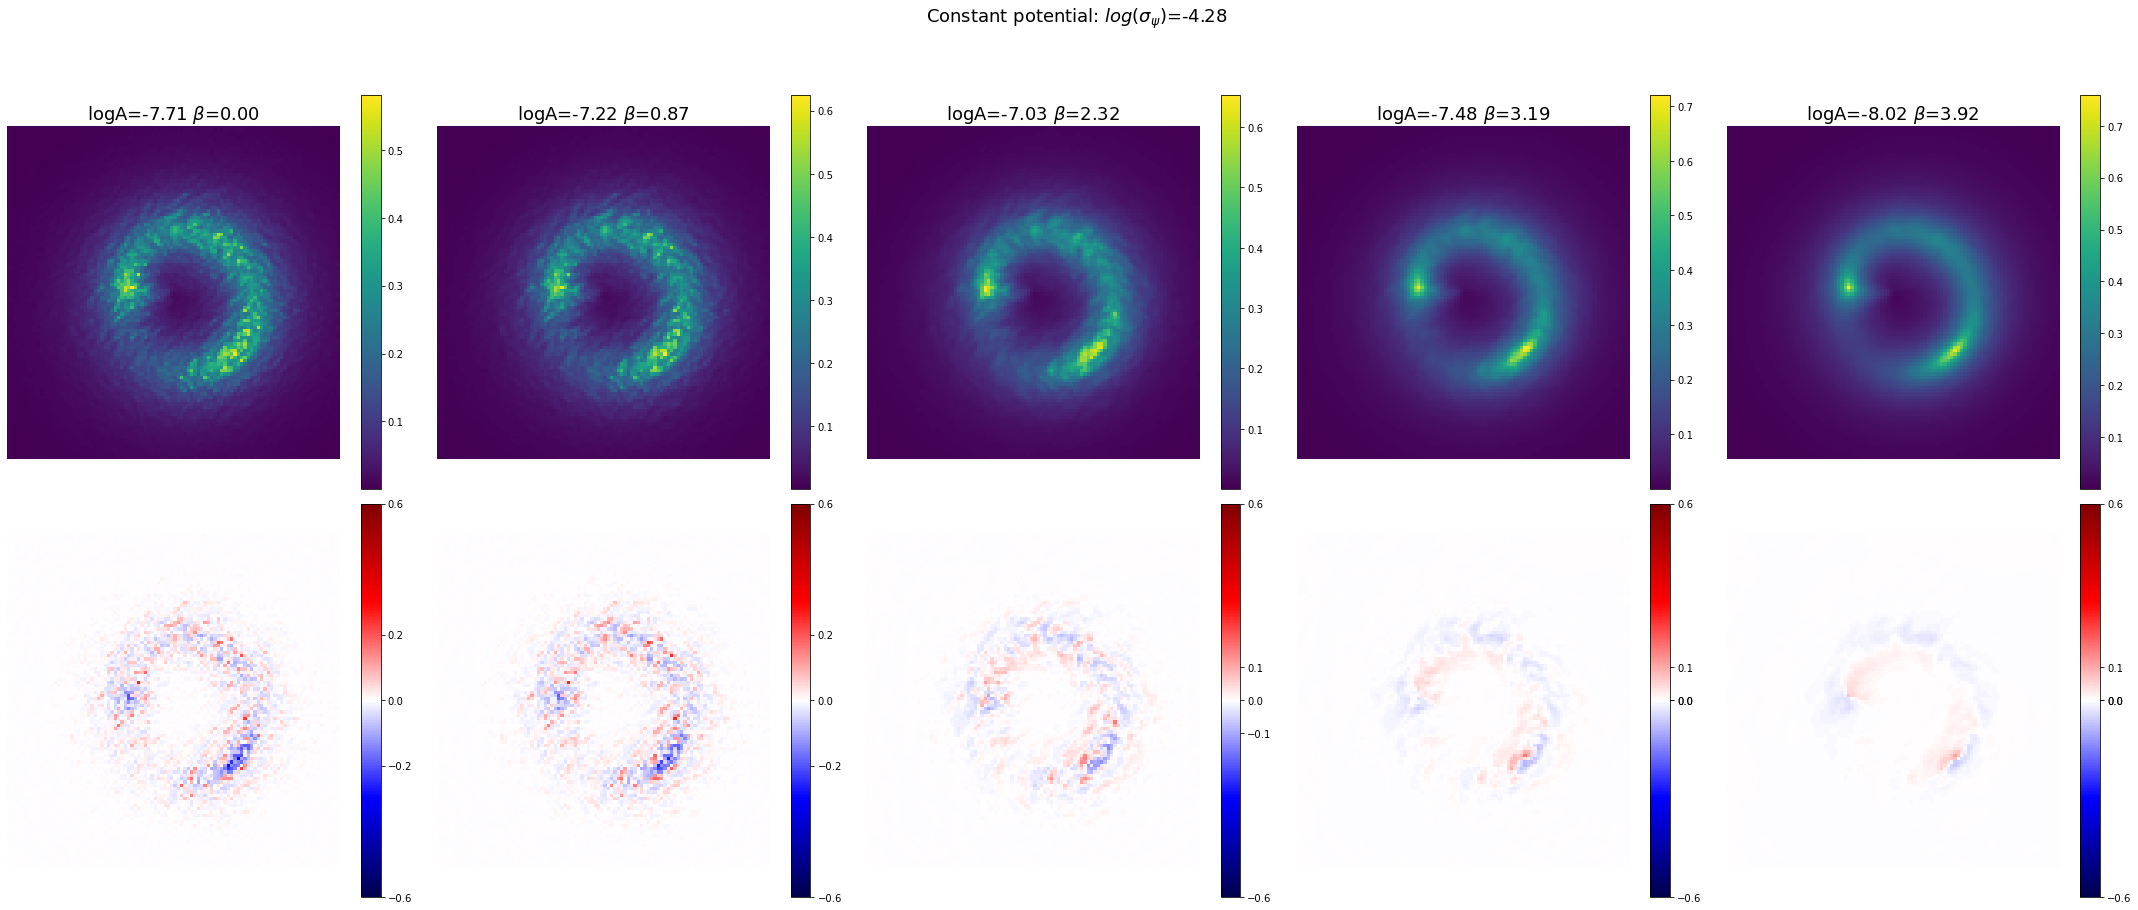

In [222]:
fig,ax=plt.subplots(2,5,figsize=(30,12))

images=np.array([data_images,data_images-Image_unperturbed_noiseless])

#Normalized masked residuals
#images[1,:]/=np.sqrt(Observation_conditions.noise_var)
#images[1,:]*=Observation_conditions.annulus_mask


for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(len(crop_logA_arr)):
        axis=axis_row[j]
        image=images[i,j]
        
        if i==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
            axis.set_title('logA={:.2f} '.format(crop_logA_arr[j])+r'$\beta$'+'={:.2f}'.format(crop_Beta_arr[j]),fontsize=FS)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-0.6,0.6))
            #img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[-0.6,math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1,0.6]
    
            #cbar=fig.colorbar(img,ax=axis,fraction=0.045)
            #cbar=fig.colorbar(img,ax=axis,ticks=[-0.7,0,0.7],fraction=0.045)
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders)
            #cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
            #cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.axis('off')
        
plt.suptitle('Constant potential: '+r'$log(\sigma_{\psi})$'+'={:.2f}'.format(thresh_pot),fontsize=FS,y=1.05)
plt.tight_layout()
plt.show()

## Convergence based

In [223]:
from skimage import measure

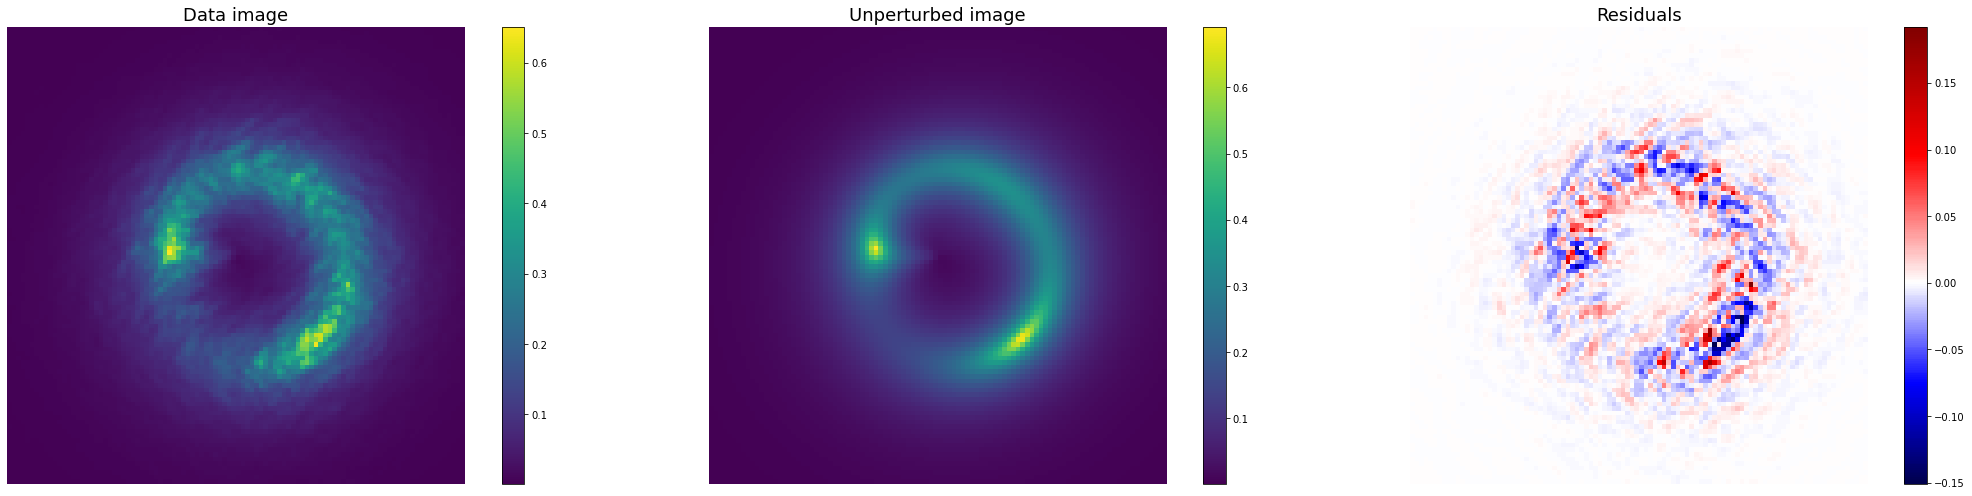

In [224]:
GRF_params=[-7.008,2.]
_,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [225]:
i=np.argmin(np.abs(logA_array_Physical-GRF_params[0]))
j=np.argmin(np.abs(Beta_array_Physical-GRF_params[1]))
thresh_conv=np.log(std_convergence)[i,j]
print(thresh_conv)

1.5949766670602188


In [226]:
indices=measure.find_contours(np.log(std_convergence),thresh_conv)
indices=np.append(indices[0],indices[1],axis=0)
#indices=indices[0]

logA_values=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_values=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

step=len(indices)//5

crop_logA_arr=logA_values[::step]
crop_Beta_arr=Beta_values[::step]

In [227]:
len(indices)/5

9.8

In [228]:
data_images=np.zeros((len(crop_logA_arr),100,100))

for i in range(len(crop_logA_arr)):
    GRF_params=[crop_logA_arr[i],crop_Beta_arr[i]]
    _,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False,Noise_flag=False)
    data_images[i]=data_image

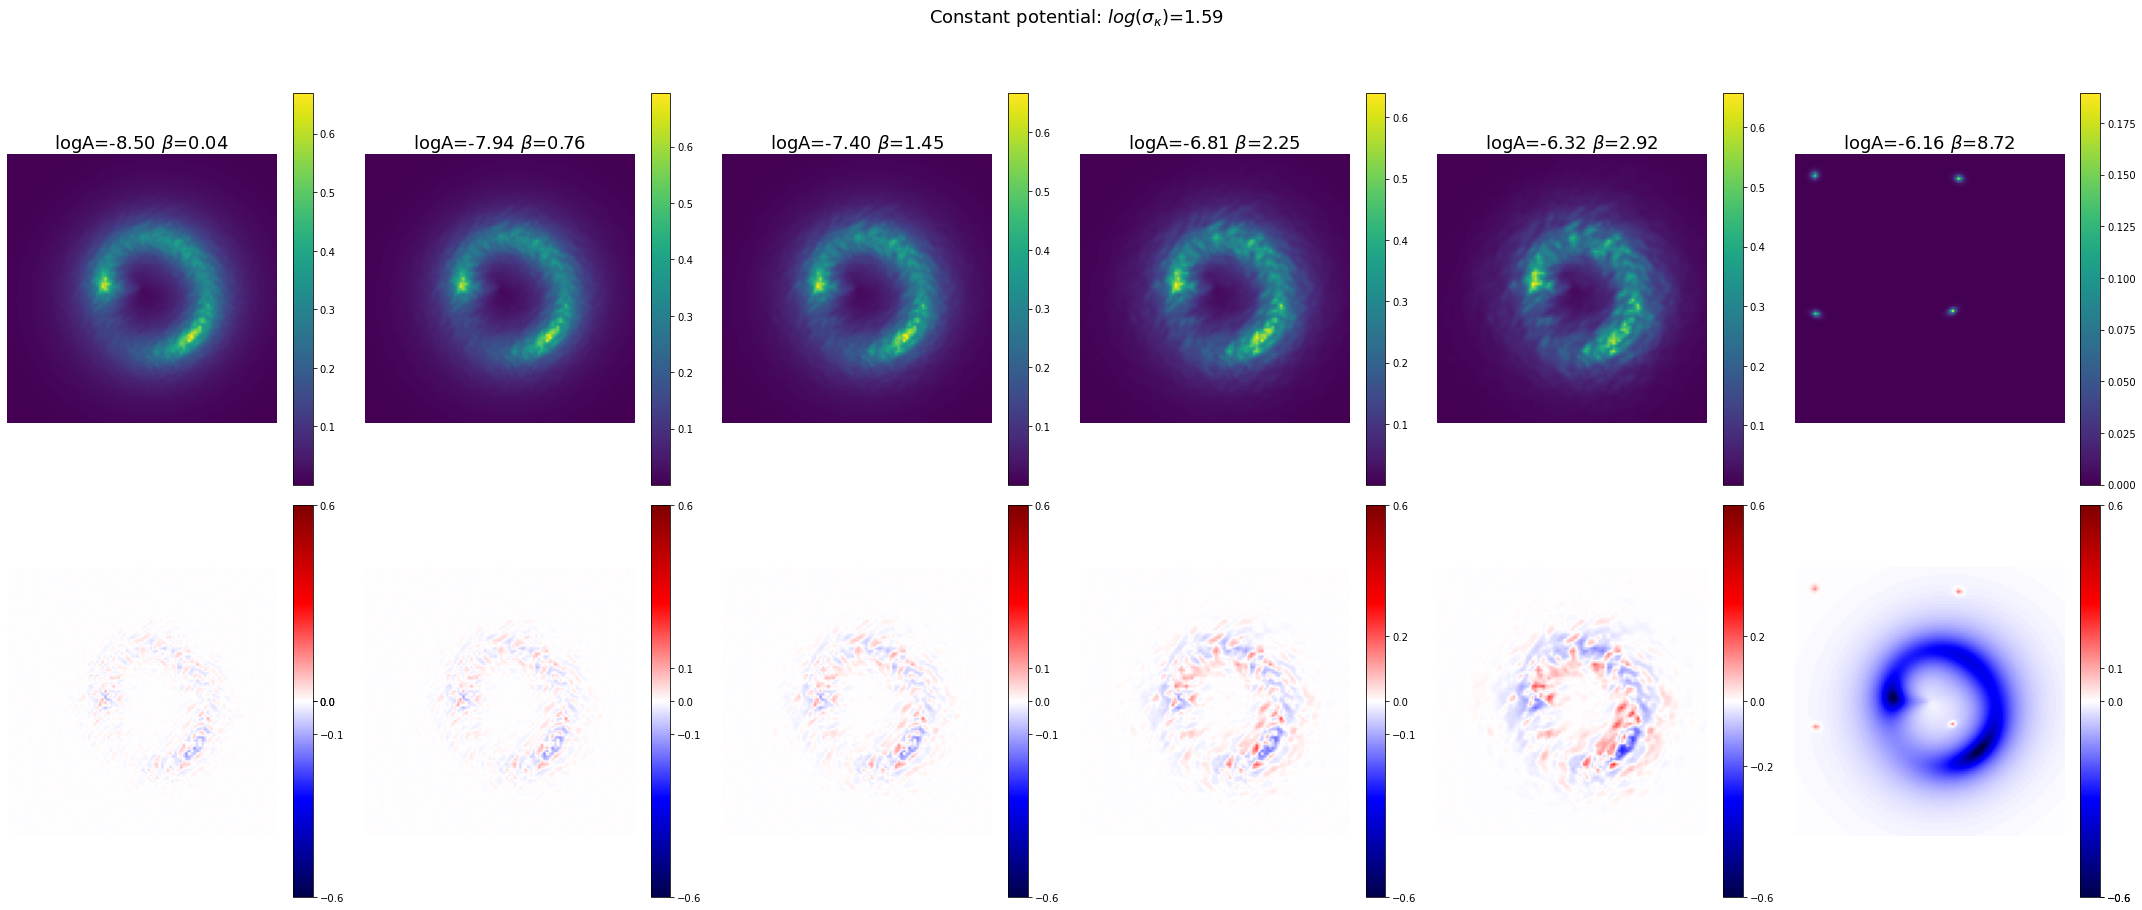

In [229]:
fig,ax=plt.subplots(2,len(crop_logA_arr),figsize=(30,12))

images=np.array([data_images,data_images-Image_unperturbed_noiseless])

#Normalized masked residuals
#images[1,:]/=np.sqrt(Observation_conditions.noise_var)
#images[1,:]*=Observation_conditions.annulus_mask


for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(len(crop_logA_arr)):
        axis=axis_row[j]
        image=images[i,j]
        
        if i==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
            axis.set_title('logA={:.2f} '.format(crop_logA_arr[j])+r'$\beta$'+'={:.2f}'.format(crop_Beta_arr[j]),fontsize=FS)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-0.6,0.6))
            #img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[-0.6,math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1,0.6]
    
            #cbar=fig.colorbar(img,ax=axis,fraction=0.045)
            #cbar=fig.colorbar(img,ax=axis,ticks=[-0.7,0,0.7],fraction=0.045)
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders)
            #cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
            #cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.axis('off')
        
plt.suptitle('Constant potential: '+r'$log(\sigma_{\kappa})$'+'={:.2f}'.format(thresh_conv),fontsize=FS,y=1.05)
plt.tight_layout()
plt.show()